#**Size and Color Sorting :**

the program can devicdid into 4 steps :

- Isolating the fruit from the cub and the back ground. 
- Detecting it's shape. 
- From shape we can get diameter and size. 
- get the color by averaging the RGB in of the fruit pixls 


# **Code**

**First let's import some libraries that we will use later** 

In [0]:
# important libraries 
import cv2
import pandas as pd
import numpy as np
import imutils
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import time 
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

**Safe division function so we don't crash so often**

In [0]:
def safe_div(x,y): 
    if y==0: return 0
    return x/y

**To get the midpoint between two points :**

In [0]:
def midpoint(ptA, ptB): 
  return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

**To detect just the fruit (removing background and the cub)which is in different color with the white background**

In [0]:
def thesholding(image , thresh = 75 ,thresh2 = 240 ):

  # If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value   
  ret,thresholded = cv2.threshold(image,thresh,255,cv2.THRESH_BINARY_INV) 

 # to remove the black cub  by another threshold
  gray = cv2.cvtColor(thresholded, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray, thresh2, 255, cv2.THRESH_BINARY)
  thresholded[thresh == 255] = 0

  return thresholded

**Remove all small colored pixels and make the shape easier to detect:**

In [0]:
def getsturct(thresholded , kern= 5 , itera= 1):

  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

  thresh_getstruct = cv2.erode(thresholded, kernel, iterations = 1)

  kernel = np.ones((kern,kern),np.uint8) # square image kernel used for erosion
  
  dilation = cv2.dilate(thresh_getstruct, kernel, iterations=itera)
  erosion = cv2.erode(dilation,kernel,iterations = itera) # refines all edges in the binary image

 #Opening is just another name of erosion followed by dilation. It is useful in removing noise
  opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel) 

#Closing is reverse of Opening, Dilation followed by Erosion. It is useful in closing small holes inside the foreground objects
  closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel) 
  
  closing[closing > 0] = 255

 
  return closing

**Convert Photo to balck and white so we can get shape using opencv fuction**

In [0]:
def toblackandwhite(ttt):

  ttt = cv2.bitwise_not(ttt)
  ccc = ttt
  image2 = np.zeros(image.shape, np.uint8)
  ccc = cv2.cvtColor(ccc, cv2.COLOR_BGR2GRAY)
  image2[ccc < 255] =255

  return image2

**Get the shape**

In [0]:
def findbiggestcontour(closing):
  closing = cv2.cvtColor(closing, cv2.COLOR_BGR2GRAY)
    # find contours with simple approximation cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE
  contours,hierarchy = cv2.findContours(closing,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) 
  #print(contours)
  closing = cv2.cvtColor(closing,cv2.COLOR_GRAY2RGB)
    
  #focus on only the largest outline by area
  areas = [] #list to hold all areas

  for contour in contours:
    ar = cv2.contourArea(contour)
    areas.append(ar)

  if areas :
    max_area = max(areas)
    max_area_index = areas.index(max_area)  # index of the list element with largest area
    cnt = contours[max_area_index - 1] # largest area contour is usually the viewing window itself, why?
    return cnt , areas , contours
  else :
    return 0 , areas , contours

**Draw box round the shape and get the points**

In [0]:
def find_box_points(orig , cnt):

  # compute the rotated bounding box of the contour
  box = cv2.minAreaRect(cnt) #Finds a rotated rectangle of the minimum area enclosing the input 2D point set.
  box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
  box = np.array(box, dtype="int")

  # order the points in the contour such that they appear in top-left, top-right, bottom-right, and bottom-left order
  # then draw the outline of the rotated bounding box
  box = perspective.order_points(box)

  # loop over the original points and draw box points 
  #for (x, y) in box:
    #cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)

  return box , orig  

**Get Diameter**

In [0]:
def Diamerterandcenter(box , cnt):

  # unpack the ordered bounding box, then compute the midpoint
  # between the top-left and top-right coordinates, followed by
  # the midpoint between bottom-left and bottom-right coordinates
  (tl, tr, br, bl) = box
  print(tl)
  (tltrX, tltrY) = midpoint(tl, tr)
  (blbrX, blbrY) = midpoint(bl, br)
        
  # compute the midpoint between the top-left and bottom-left points,
  # followed by the midpoint between the top-righ and bottom-right
  (tlblX, tlblY) = midpoint(tl, bl)
  (trbrX, trbrY) = midpoint(tr, br)
    
  # compute the Euclidean distance between the midpoints
  dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
  dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
  dC = dist.euclidean((tl[0], tl[1]), (br[0], br[1]))
  dD = dist.euclidean((tr[0], tr[1]), (bl[0], bl[1]))  

  # compute the size of the object
  pixelsPerMetric = 3 # more to do here to get actual measurements that have meaning in the real world
  dimA = dA / pixelsPerMetric
  dimB = dB / pixelsPerMetric
  dimC = dC / pixelsPerMetric
  dimD = dD / pixelsPerMetric

              
  # compute the center of the contour
  M = cv2.moments(cnt)
  cX = int(safe_div(M["m10"],M["m00"]))
  cY = int(safe_div(M["m01"],M["m00"]))

  return dimA , dimB , cX , cY , tltrX, tltrY , blbrX, blbrY , tlblX, tlblY , trbrX, trbrY , tl, tr, br, bl ,dimC ,dimD


**Draw box , contour and diameter line for illustration**

In [0]:
def drawings(closing ,orig , ctt , cX, cY ,mean , contours , box , tltrX, tltrY , blbrX, blbrY , tlblX, tlblY , trbrX, trbrY , dimA , dimB , tl, tr, br, bl,dimC ,dimD):

  cv2.rectangle(orig,(500,350),(600,450),(int(mean[0]), int(mean[1]), int(mean[2])),-1)
  cv2.drawContours(closing, contours, -1, (128,255,0), 1)
  cv2.drawContours(closing, [ctt], 0, (0,0,255), 1)
  cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 1)

  #draw the midpoints on the image
  cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
  cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
  cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
  cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
     
  #draw lines between the midpoints
  cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),(255, 0, 255), 1)
  cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),(255, 0, 255), 1)

  cv2.line(orig, (int(tl[0]), int(tl[1])), (int(br[0]), int(br[1])),(255, 0, 255), 1)
  cv2.line(orig, (int(tr[0]), int(tr[1])), (int(bl[0]), int(bl[1])),(255, 0, 255), 1)
  cv2.drawContours(orig, [ctt], 0, (0,0,255), 1)
            
  #draw the object sizes on the image
  cv2.putText(orig, "{:.1f}mm".format(dimA), (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)
  cv2.putText(orig, "{:.1f}mm".format(dimB), (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)
  cv2.putText(orig, "{:.1f}mm".format(dimC), (int(tl[0] - 15), int(tl[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)
  cv2.putText(orig, "{:.1f}mm".format(dimD), (int(bl[0] + 10), int(bl[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)

 
  # draw the contour and center of the shape on the image
  cv2.circle(orig, (cX, cY), 5, (255, 255, 255), -1)
  cv2.putText(orig, "center", (cX - 20, cY - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
  return closing ,orig


**Main code for testing**

In [0]:
def getcolornsize(image):

  thresholded = thesholding(image)   

  closing = getsturct(thresholded)
  blackandwhite = toblackandwhite(closing)
  ctt , areas, contours = findbiggestcontour(blackandwhite)
  
  #print(ctt)
  #print(areas)
  orig = image.copy()

  if areas :

    box , orig = find_box_points(orig , ctt)
    dimA , dimB , cX , cY , tltrX, tltrY , blbrX, blbrY , tlblX, tlblY , trbrX, trbrY , tl, tr, br, bl ,dimC , dimD = Diamerterandcenter(box, ctt)
    print('dimA = ' , dimA,'dimB = ' , dimB,'cX = ' , cX,'cY = ' , cY)

    if (dimA < 140 and dimA > 40) or (dimB < 140 and dimB > 40) :

      mask = np.zeros(image.shape[:2], np.uint8)
        
      cv2.drawContours(mask, ctt, -1, 255, -1)
      cv2.fillPoly(mask, pts =[ctt], color=(255,0,0))
    
      mean = cv2.mean(image, mask=mask)
      print('mean is' , mean)

      origeee = image.copy()
    
      origeee[mask == 0] = 255

      closing ,orig = drawings(closing ,orig , ctt ,cX, cY , mean ,contours,box , tltrX, tltrY , blbrX, blbrY , tlblX, tlblY , trbrX, trbrY,dimA , dimB, tl, tr, br, bl,dimC , dimD)

  f, axs = plt.subplots(1,2,figsize=(30,30))
  plt.subplot(1, 6, 1)
  plt.imshow(image)
  plt.subplot(1, 6, 2)
  plt.imshow(thresholded)
  plt.subplot(1, 6, 3)
  plt.imshow(closing) 
  plt.subplot(1, 6, 4)
  plt.imshow(blackandwhite) 
  plt.subplot(1, 6, 5)
  plt.imshow(orig)
  plt.subplot(1, 6, 6)
  plt.imshow(origeee)
  return 0


# **Test**

[ 69. 152.]
dimA =  96.37153221891941 dimB =  91.79581810857302 cX =  261 cY =  205
mean is (185.47415546132385, 124.757302520611, 16.248876838438136, 0.0)


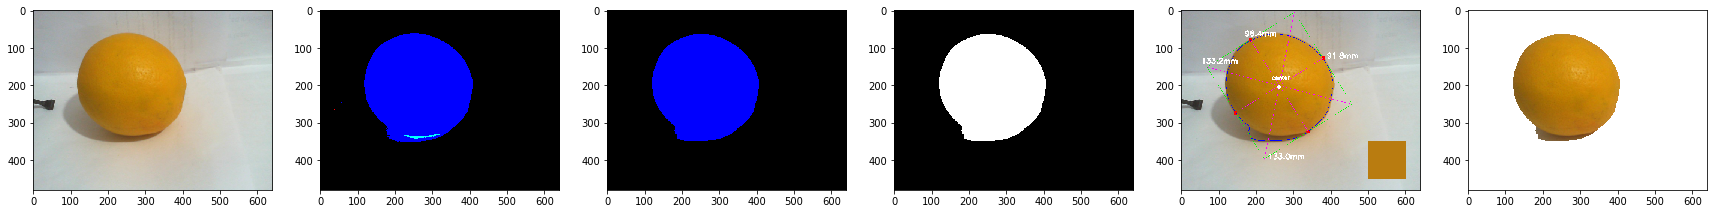

In [0]:
image= mpimg.imread('/content/26.jpg', 0)
ttt = getcolornsize(image)

[ 91. 211.]
dimA =  76.96752561957543 dimB =  77.27080805697439 cX =  245 cY =  267
mean is (197.09663914680638, 132.70016605468112, 16.9140491615408, 0.0)


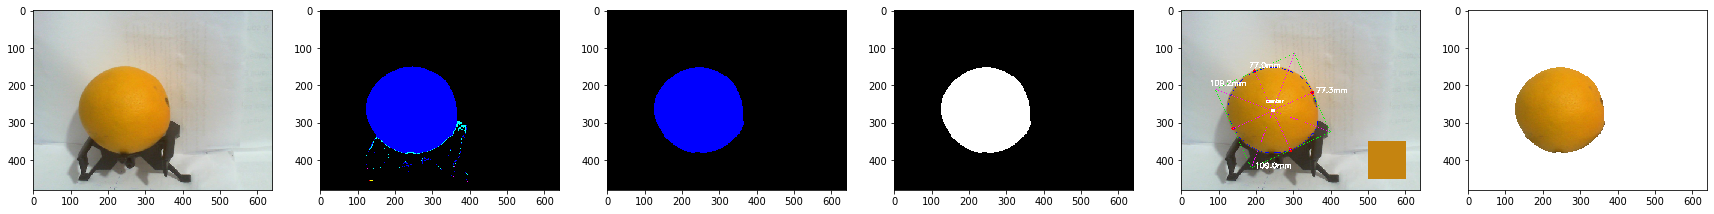

In [0]:
image= mpimg.imread('/content/166.jpg', 0)
ttt = getcolornsize(image)

[251. 148.]
dimA =  69.35756787995253 dimB =  71.52796655854267 cX =  362 cY =  246
mean is (190.03798892106965, 71.14186092286927, 37.83980541574108, 0.0)


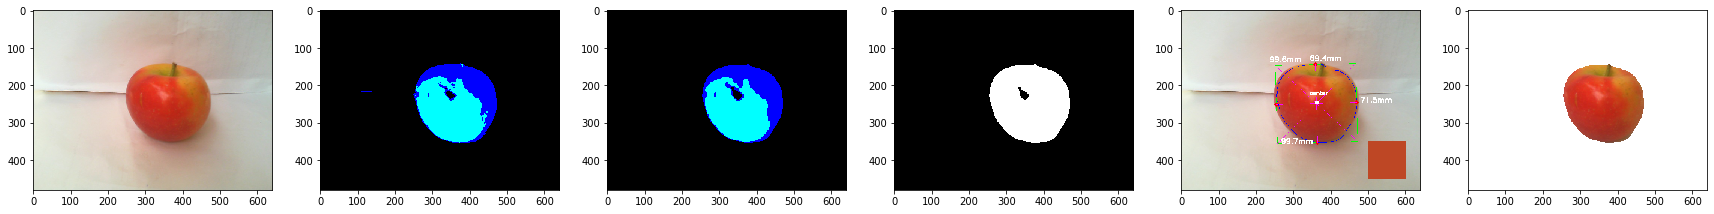

In [0]:
image= mpimg.imread('/content/498.jpg', 0)
ttt = getcolornsize(image)

[229. 298.]
dimA =  52.666666666666664 dimB =  51.666666666666664 cX =  305 cY =  377
mean is (119.14499768292055, 109.22944235621235, 26.094536841563258, 0.0)


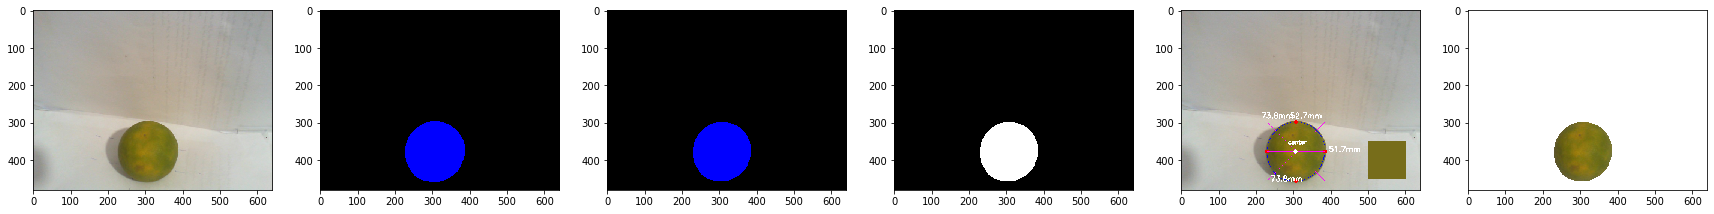

In [0]:
image= mpimg.imread('/content/96.jpg', 0)
ttt = getcolornsize(image)

[166.  97.]
dimA =  75.66666666666667 dimB =  79.66666666666667 cX =  283 cY =  213
mean is (181.20452621221483, 120.62845243815931, 13.569048763186197, 0.0)


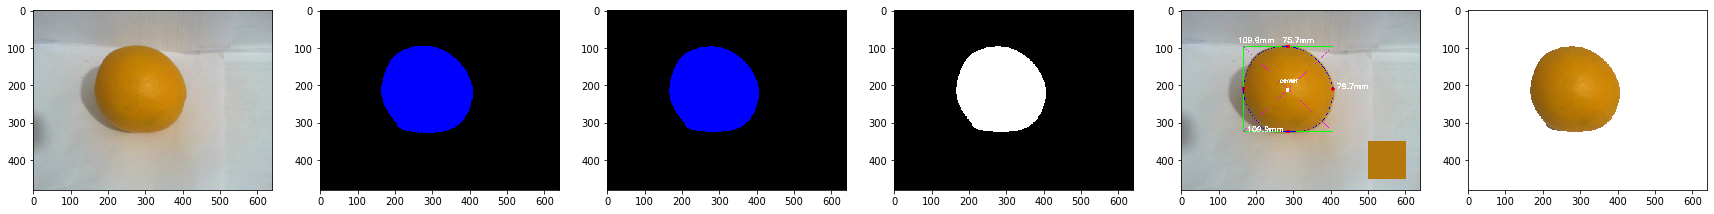

In [29]:
image= mpimg.imread('/content/74.jpg', 0)
ttt = getcolornsize(image)

# **Code to run locally**

In [0]:
import cv2
import pandas as pd
import numpy as np
import imutils
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import time 
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.pyplot as plt


def safe_div(x,y): # so we don't crash so often
    if y==0: return 0
    return x/y

def nothing(x): # for trackbar
    pass


def rescale_frame(frame, percent=100):  # make the video windows a bit smaller
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)

#----------------------------------------------------------------------
#----------------------------------------------------------------------    

def midpoint(ptA, ptB): 
  return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

#----------------------------------------------------------------------
#----------------------------------------------------------------------

def thesholding(image , thresh = 75 ,thresh2 = 200 ):

  # to detect just the fruit (removing background and the cub)

  # to detect the fruit wich is in defferent color with the white background 
  # If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value   
  
  ret,thresholded = cv2.threshold(image,thresh,255,cv2.THRESH_BINARY_INV) 

 # to remove the black cub 
  #gray = cv2.cvtColor(thresholded, cv2.COLOR_BGR2GRAY)
  #ret, thresh = cv2.threshold(gray, thresh2, 255, cv2.THRESH_BINARY)
  #thresholded[thresh == 255] = 0

  return thresholded

#---------------------------------------------------------------------
#---------------------------------------------------------------------

def getsturct(thresholded , kern= 5 , itera= 1):

#remove all small colored pixels and detect shape

  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
  #try iterations = 2
  thresh_getstruct = cv2.erode(thresholded, kernel, iterations = 1)

  kernel = np.ones((kern,kern),np.uint8) # square image kernel used for erosion
  
  dilation = cv2.dilate(thresh_getstruct, kernel, iterations=itera)
  erosion = cv2.erode(dilation,kernel,iterations = itera) # refines all edges in the binary image

 #Opening is just another name of erosion followed by dilation. It is useful in removing noise
  opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel) 

#Closing is reverse of Opening, Dilation followed by Erosion. It is useful in closing small holes inside the foreground objects
  closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel) 
  
  closing[closing > 0] = 255

 
  return closing
 
 #------------------------------------------------------------
 #------------------------------------------------------------

def toblackandwhite(ttt):

  ttt = cv2.bitwise_not(ttt)
  ccc = ttt
  image2 = np.zeros(frame_resize.shape, np.uint8)
  ccc = cv2.cvtColor(ccc, cv2.COLOR_BGR2GRAY)
  image2[ccc < 255] =255

  return image2




  #------------------------------------------------------------
  #------------------------------------------------------------

def findbiggestcontour(closing):
  closing = cv2.cvtColor(closing, cv2.COLOR_BGR2GRAY)
    # find contours with simple approximation cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE
  contours,hierarchy = cv2.findContours(closing,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) 
  #print(contours)
  closing = cv2.cvtColor(closing,cv2.COLOR_GRAY2RGB)
    
  #focus on only the largest outline by area
  areas = [] #list to hold all areas

  for contour in contours:
    ar = cv2.contourArea(contour)
    areas.append(ar)

  if areas :
    max_area = max(areas)
    max_area_index = areas.index(max_area)  # index of the list element with largest area
    cnt = contours[max_area_index - 1] # largest area contour is usually the viewing window itself, why?
    return cnt , areas , contours
  else :
    return 0 , areas , contours




def find_box_points(orig , cnt):

  # compute the rotated bounding box of the contour
  box = cv2.minAreaRect(cnt) #Finds a rotated rectangle of the minimum area enclosing the input 2D point set.
  box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
  box = np.array(box, dtype="int")

  # order the points in the contour such that they appear
  # in top-left, top-right, bottom-right, and bottom-left
  # order, then draw the outline of the rotated bounding
  # box
  box = perspective.order_points(box)
  # loop over the original points and draw box points 
  
  #for (x, y) in box:
    #cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)

  return box , orig      

def Diamerterandcenter(box , cnt):

  # unpack the ordered bounding box, then compute the midpoint
  # between the top-left and top-right coordinates, followed by
  # the midpoint between bottom-left and bottom-right coordinates
  (tl, tr, br, bl) = box
  #print(tl)
  (tltrX, tltrY) = midpoint(tl, tr)
  (blbrX, blbrY) = midpoint(bl, br)
        
  # compute the midpoint between the top-left and bottom-left points,
  # followed by the midpoint between the top-righ and bottom-right
  (tlblX, tlblY) = midpoint(tl, bl)
  (trbrX, trbrY) = midpoint(tr, br)
    
  # compute the Euclidean distance between the midpoints
  dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
  dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
  dC = dist.euclidean((tl[0], tl[1]), (br[0], br[1]))
  dD = dist.euclidean((tr[0], tr[1]), (bl[0], bl[1]))  

  # compute the size of the object
  pixelsPerMetric = 3 # more to do here to get actual measurements that have meaning in the real world
  dimA = dA / pixelsPerMetric
  dimB = dB / pixelsPerMetric
  dimC = dC / pixelsPerMetric
  dimD = dD / pixelsPerMetric

              
  # compute the center of the contour
  M = cv2.moments(cnt)
  cX = int(safe_div(M["m10"],M["m00"]))
  cY = int(safe_div(M["m01"],M["m00"]))

  return dimA , dimB , cX , cY , tltrX, tltrY , blbrX, blbrY , tlblX, tlblY , trbrX, trbrY , tl, tr, br, bl ,dimC ,dimD


def drawings(closing ,orig , ctt , cX, cY ,mean , contours , box , tltrX, tltrY , blbrX, blbrY , tlblX, tlblY , trbrX, trbrY , dimA , dimB , tl, tr, br, bl,dimC ,dimD):

  cv2.rectangle(orig,(500,350),(600,450),(int(mean[0]), int(mean[1]), int(mean[2])),-1)
  cv2.drawContours(closing, contours, -1, (128,255,0), 1)
  cv2.drawContours(closing, [ctt], 0, (0,0,255), 1)
  cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 1)

  #draw the midpoints on the image
  cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
  cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
  cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
  cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
     
  #draw lines between the midpoints
  cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),(255, 0, 255), 1)
  cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),(255, 0, 255), 1)

  cv2.line(orig, (int(tl[0]), int(tl[1])), (int(br[0]), int(br[1])),(255, 0, 255), 1)
  cv2.line(orig, (int(bl[0]), int(bl[1])), (int(tr[0]), int(tr[1])),(255, 0, 255), 1)


  cv2.drawContours(orig, [ctt], 0, (0,0,255), 1)
            
  #draw the object sizes on the image
  cv2.putText(orig, "{:.1f}mm".format(dimA), (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)
  cv2.putText(orig, "{:.1f}mm".format(dimB), (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)
  cv2.putText(orig, "{:.1f}mm".format(dimC), (int(tl[0] - 15), int(tl[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)
  cv2.putText(orig, "{:.1f}mm".format(dimD), (int(bl[0] + 10), int(bl[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)

 
  # draw the contour and center of the shape on the image
  cv2.circle(orig, (cX, cY), 5, (255, 255, 255), -1)
  cv2.putText(orig, "center", (cX - 20, cY - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
  return closing ,orig


# using cam built-in to computer
videocapture=cv2.VideoCapture(1)


    
windowName="Webcam Live video feed"

cv2.namedWindow(windowName)

cv2.createTrackbar("threshold", windowName, 75, 255, nothing)
cv2.createTrackbar("kernel", windowName, 5, 30, nothing)
cv2.createTrackbar("iterations", windowName, 1, 10, nothing)

showLive=True
while(showLive):
    t1 = time.time()
    ret, frame=videocapture.read()
    

    frame_resize = rescale_frame(frame)

    if not ret:
        print("cannot capture the frame")
        exit()
   
    thresh= cv2.getTrackbarPos("threshold", windowName)
 
    kern=cv2.getTrackbarPos("kernel", windowName) 
    
    itera=cv2.getTrackbarPos("iterations", windowName) 

    
    thresholded = thesholding(frame_resize , thresh)   

    closing = getsturct(thresholded,kern, itera)
    blackandwhite = toblackandwhite(closing)
    ctt , areas, contours = findbiggestcontour(blackandwhite)
  
    #print(ctt)
    #print(areas)
    orig = frame_resize.copy()

    if areas :

        box , orig = find_box_points(orig , ctt)
        dimA , dimB , cX , cY , tltrX, tltrY , blbrX, blbrY , tlblX, tlblY , trbrX, trbrY , tl, tr, br, bl ,dimC , dimD = Diamerterandcenter(box, ctt)
        #print('dimA = ' , dimA,'dimB = ' , dimB,'cX = ' , cX,'cY = ' , cY)
        print('dimA = ' , int(dimA),'dimB = ' , int(dimB))

        if (dimA < 140 and dimA > 40) or (dimB < 140 and dimB > 40) :

            mask = np.zeros(frame_resize.shape[:2], np.uint8)
            
            cv2.drawContours(mask, ctt, -1, 255, -1)
            cv2.fillPoly(mask, pts =[ctt], color=(255,0,0))
    
            mean = cv2.mean(frame_resize, mask=mask)
            #print('mean is' , mean)

            origeee = frame_resize.copy()
    
            origeee[mask == 0] = 255

            closing ,orig = drawings(closing ,orig , ctt ,cX, cY , mean ,contours,box , tltrX, tltrY , blbrX, blbrY , tlblX, tlblY , trbrX, trbrY,dimA , dimB, tl, tr, br, bl,dimC , dimD)

  
 

      

  
  
        t2 = time.time()
        t = t2 - t1
        print('time = ', t)
        cv2.imshow(windowName, orig)
        cv2.imshow('--', blackandwhite)
        #cv2.imshow('mask', mask)

        if cv2.waitKey(30)>=0:
            showLive=False
    else :
        cv2.imshow(windowName, frame)
        cv2.imshow('--', blackandwhite)
        if cv2.waitKey(30)>=0:
            showLive=False

        
videocapture.release()
cv2.destroyAllWindows()
